# Segmentation of Indian Traffic

In [1]:
import os
import re
import cv2
import math
import json
import urllib
import pickle
import shutil

##############################################################
import gdown

id = '1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ'
gdown.download(id =id, quiet = True)
##############################################################

import numpy as np
from os import path
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from PIL import ImagePath
from PIL import Image, ImageDraw

plt.style.use('fivethirtyeight')

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [2]:
!unzip -q data.zip

# Directory to save processed files

if not os.path.isdir('results'):
    os.makedirs('results/unet')
    os.makedirs('results/canet')

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [3]:
!rm data.zip

def return_file_names_df(root_dir):
    
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    
    images_l = []
    mask_l = []
    
    for folder in sorted(os.listdir(root_dir)):
        folder_dir = os.path.join(root_dir, folder)
        for in_folder in sorted(os.listdir(folder_dir)):
            files_dir = os.path.join(folder_dir, in_folder)
            for files in sorted(os.listdir(files_dir)):
                if folder == 'images':
                    images_l.append(os.path.join(files_dir, files))
                if folder == 'mask':
                    mask_l.append(os.path.join(files_dir, files))
                    
    data_df = pd.DataFrame({'image' : images_l, 'json' : mask_l})
    
    return data_df

In [4]:
root_dir = 'data'
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [5]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and \
                i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            
            return False
    return True

In [6]:
grader_1(data_df)

True

In [7]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [8]:
def return_unique_labels(data_df):
    
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    
    unique_labels = set()
    
    for row in tqdm(data_df['json']):
        with open(row) as f:
            json_r = json.load(f)
        for obj in json_r['objects']:
            unique_labels.add(obj['label'])
            
    return unique_labels

In [9]:
unique_labels = return_unique_labels(data_df)
print(f'Length of unique_labels :: {len(unique_labels)}')

100%|██████████| 4008/4008 [00:21<00:00, 187.75it/s]

Length of unique_labels :: 40


<img src='https://i.imgur.com/L4QH6Tp.png'>

In [10]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40, \
             'rail track':40, 'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, \
             'autorickshaw':80, 'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, \
             'caravan':90, 'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120, \
             'traffic sign':120, 'traffic light':120, 'pole':130, 'polegroup':130, \
             'obs-str-bar-fallback':130,'building':140, 'bridge':140,'tunnel':140, 'vegetation':150, \
             'sky':160, 'fallback background':160,'unlabeled':0, 'out of roi':0, 'ego vehicle':170, \
             'ground':180,'rectification border':190, 'train':200}

In [11]:
def grader_2(unique_labels):
    
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [12]:
def get_poly(file):
    
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    
    label = []
    vertexlist = []
   
    with open(file) as f:
        json_r = json.load(f)
        h = json_r['imgHeight']
        w = json_r['imgWidth']
        for obj in json_r['objects']:
                label.append(obj['label'])
                vertexlist.append([tuple(vertex) for vertex in obj['polygon']])
                
    return w, h, label, vertexlist

In [13]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and \
          isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

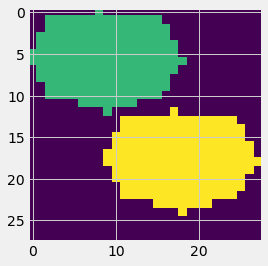

In [14]:
from PIL import Image, ImageDraw 
from PIL import ImagePath  

side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("results/test_image.png")

In [15]:
# https://stackoverflow.com/a/13819575

def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    mask_l = []
    
    mask_output_dir = 'data/output'
    if os.path.isdir(mask_output_dir):
        shutil.rmtree(mask_output_dir)
    os.mkdir(mask_output_dir)
    
    for row in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(row)
            
        img = Image.new('RGB', (w, h))
        img1 = ImageDraw.Draw(img)
        
        for idx, label in enumerate(labels):
            if len(vertexlist[idx]) > 1:
                img1.polygon(vertexlist[idx], fill = label_clr[labels[idx]])
                
#         for i in range(len(labels)):
#             if(len(vertexlist[i])>1):
#                 img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        
        img = np.array(img)
        im = Image.fromarray(img[:, :, 0])
        
        new_name = re.sub(r'mask', 'output', row)
        new_name = re.sub(r'json', 'png', new_name)
        
#         after drawing all the polygons that we collected from json file,
#         you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
        
        os.makedirs(mask_output_dir + '/' + new_name.split('/')[2], exist_ok = True)
        im.save(new_name)
        mask_l.append(new_name)
        
#         after saving the image into disk, store the path in a list
#         after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
            
    data_df['mask'] = mask_l

    return data_df

In [16]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [03:59<00:00, 16.76it/s]


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


## Saving Results

In [17]:
# saving the final dataframe to a csv file

if not os.path.isdir('results'):
    os.mkdir('results')
    
data_df.to_csv('results/preprocessed_data.csv', index = False)
print("Preprocessed Data saved sucessfully at 'results/preprocessed_data.csv' directory")

Preprocessed Data saved sucessfully at 'results/preprocessed_data.csv' directory


In [18]:
with open('results/label_clr.pkl', 'wb') as f:
    pickle.dump(label_clr, f, protocol=pickle.HIGHEST_PROTOCOL)

# <font color = 'red'>Acceptance Threshold</font>

<img src = 'https://i.imgur.com/dzfkzbK.png'>

# Task 2: Applying Unet to segment the images

* please check the paper: <a href="https://arxiv.org/abs/1505.04597">https://arxiv.org/abs/1505.04597</a> (<a href="https://arxiv.org/pdf/1505.04597">Download PDF</a>)


* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">


* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library [https://github.com/qubvel/segmentation_models](https://github.com/qubvel/segmentation_models)

* You can install it like this `pip install -U segmentation-models==0.2.1`, even in google colab you can install the same with `!pip install -U segmentation-models==0.2.1`

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [19]:
import os
import cv2
import pickle
import random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

import imgaug.augmenters as iaa

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

The version `segmentation-models==0.2.1` generating errors continuesly.Thus following [official documentation](https://github.com/qubvel/segmentation_models#installation)

Current versions of packages,
```bash
tensorflow==2.10.0
segmentation-models==1.0.1
imgaug==0.4.0

pip install imgaug==0.4.0
```

In [20]:
# https://github.com/qubvel/segmentation_models

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score # Intersection over Union

tf.keras.backend.set_image_data_format('channels_last')
# sm.set_framework('tf.keras')
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [21]:
# Constatnts

data_df = pd.read_csv('results/preprocessed_data.csv') 
with open('results/label_clr.pkl', 'rb') as f:
    label_clr = pickle.load(f)
    
EPOCH = 15
IMG_SIZE = 128
SEED_value = 42
BATCH_SIZE = 24
NUM_CLASSES = 21

In [22]:
# https://github.com/qubvel/segmentation_models#models-and-backbones

BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)

model_unet = Unet(BACKBONE, encoder_weights = 'imagenet', classes = NUM_CLASSES, \
                  activation = 'softmax', input_shape = (IMG_SIZE, IMG_SIZE, 3))
            # 'adding encoder_freeze = True' reduces the IOU value

model_unet.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                             

In [23]:
# Image augumentation techniques

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [24]:
def visualize(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

class Dataset:

    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    
    def __init__(self,basepath, img_files, mask_files, CLASSES, img_size):
        
        self.img_ids = img_files
        self.mask_ids = mask_files
        self.img_size = img_size
        
        # the paths of images
        self.images_fps = [os.path.join(basepath, image_id) for image_id in self.img_ids]
        
        # the paths of segmentation images
        self.masks_fps = [os.path.join(basepath, mask_id) for mask_id in self.mask_ids]
        
        # giving labels for each class
        self.class_values = CLASSES
        self.CLASSES = CLASSES
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(self.img_size, self.img_size), interpolation = cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)
        
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask  = cv2.resize(mask,(self.img_size, self.img_size), interpolation = cv2.INTER_NEAREST)
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        
        if self.images_fps[i] in X_train:
            
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = aug5.augment_image(image_mask)
                # image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)

        return image, image_mask
        
    def __len__(self):
        return len(self.img_ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [25]:
X_train, X_test = train_test_split(data_df, test_size = 0.13)

In [26]:
CLASSES = list(np.unique(list(label_clr.values())))

basepath = '/content/'


train_dataset = Dataset(basepath, X_train['image'].values, X_train['mask'].values, \
                        CLASSES, img_size = IMG_SIZE)

test_dataset  = Dataset(basepath, X_test['image'].values, X_test['mask'].values, \
                        CLASSES, img_size = IMG_SIZE)

train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = Dataloder(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

train_steps = X_train.shape[0]//BATCH_SIZE
valid_steps = X_test.shape[0]//BATCH_SIZE

In [27]:
def assert_check(tr_dataloader, batch_size, img_size, num_classes):

    print(f'train_dataloader[0][0].shape : {tr_dataloader[0][0].shape}')
    print(f'train_dataloader[0][1].shape : {tr_dataloader[0][1].shape}')

    assert tr_dataloader[0][0].shape == (batch_size, img_size, img_size, 3)
    assert tr_dataloader[0][1].shape == (batch_size, img_size, img_size, num_classes)
    
    return True

assert_check(train_dataloader, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)

train_dataloader[0][0].shape : (24, 128, 128, 3)
train_dataloader[0][1].shape : (24, 128, 128, 21)


True

In [28]:
# Custom Callback : https://stackoverflow.com/a/59564740

class AccThreshold(Callback):
    
    def __init__(self, thres_val):
        self.thres_val = thres_val
        
    def on_epoch_end(self, epoch, logs = {}):
        val_iou = logs.get('val_iou_score')
        if val_iou >= self.thres_val:
            print(f'\n\n\tTerminating training at epoch {epoch+1} with a minimum IntersectionOverUnion accuracy of {self.thres_val} %\n')
            self.model.stop_training = True


# Save Model
def save_models(model, res_model, model_name):
    
    model.save(f'results/{model_name}.h5')
    with open(f'results/{model_name}.txt', 'w') as file:
        file.write(str(res_model.history))

In [29]:
# Callbacks

cust_callback = AccThreshold(thres_val = 0.5)

filepath = 'results/unet/EPO_{epoch:02d}-IOU_{val_iou_score:.3f}.h5'
model_point = ModelCheckpoint(filepath, save_weights_only = True, save_best_only = True, \
                              mode = 'min', monitor = 'val_iou_score')

reduce_lr = ReduceLROnPlateau(monitor = 'val_iou_score', factor = 0.8, min_lr = 0.0001, patience = 1)

logdir = 'results/logs/unet/' + datetime.now().strftime('%d_%h%y_%H_%M_%S')
tensorBoard = TensorBoard(log_dir = logdir, histogram_freq = 0, write_graph = True)

callBacks = [model_point, tensorBoard, cust_callback, reduce_lr]

In [30]:
focal_loss = sm.losses.cce_dice_loss
optimizer_ = tf.keras.optimizers.Adam(0.01)

In [31]:
model_unet.compile(optimizer_, focal_loss, metrics = [iou_score])

In [32]:
# Model Training

model_res_unet = model_unet.fit(train_dataloader, steps_per_epoch = train_steps, epochs = EPOCH, \
                                validation_data = test_dataloader, validation_steps = valid_steps, \
                                callbacks = callBacks)

# Saving Model and model history
              
save_models(model_unet, model_res_unet, 'model_unet')

Epoch 1/15
145/145 [==============================] - 188s 1s/step - loss: 0.8913 - iou_score: 0.1264 - val_loss: 0.9313 - val_iou_score: 0.1239 - lr: 0.0100
Epoch 2/15
145/145 [==============================] - 187s 1s/step - loss: 0.8380 - iou_score: 0.1616 - val_loss: 0.9396 - val_iou_score: 0.1191 - lr: 0.0100
Epoch 3/15
145/145 [==============================] - 187s 1s/step - loss: 0.8070 - iou_score: 0.1823 - val_loss: 0.8217 - val_iou_score: 0.1752 - lr: 0.0100
Epoch 4/15
145/145 [==============================] - 167s 1s/step - loss: 0.7819 - iou_score: 0.1985 - val_loss: 0.8143 - val_iou_score: 0.1870 - lr: 0.0080
Epoch 5/15
145/145 [==============================] - 163s 1s/step - loss: 0.7617 - iou_score: 0.2122 - val_loss: 0.7885 - val_iou_score: 0.1970 - lr: 0.0064
Epoch 6/15
145/145 [==============================] - 166s 1s/step - loss: 0.7450 - iou_score: 0.2234 - val_loss: 0.7849 - val_iou_score: 0.2026 - lr: 0.0051
Epoch 7/15
145/145 [==============================] 

In [33]:
# Model Training

model_res_unet2 = model_unet.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 30, \
                                 initial_epoch = EPOCH, validation_data = test_dataloader, \
                                 validation_steps = valid_steps, callbacks = callBacks)

# Saving Model and model history
              
save_models(model_unet, model_res_unet2, 'model_unet2')

!cp -r /content/results /content/drive/MyDrive/AAIC

Epoch 16/30
145/145 [==============================] - 169s 1s/step - loss: 0.5540 - iou_score: 0.4126 - val_loss: 0.5626 - val_iou_score: 0.4161 - lr: 0.0100
Epoch 17/30
145/145 [==============================] - 172s 1s/step - loss: 0.5206 - iou_score: 0.4384 - val_loss: 0.5152 - val_iou_score: 0.4431 - lr: 0.0100
Epoch 18/30
145/145 [==============================] - 172s 1s/step - loss: 0.5045 - iou_score: 0.4499 - val_loss: 0.5104 - val_iou_score: 0.4463 - lr: 0.0080
Epoch 19/30
145/145 [==============================] - 165s 1s/step - loss: 0.4908 - iou_score: 0.4598 - val_loss: 0.5122 - val_iou_score: 0.4460 - lr: 0.0064
Epoch 20/30
145/145 [==============================] - 166s 1s/step - loss: 0.4737 - iou_score: 0.4730 - val_loss: 0.4940 - val_iou_score: 0.4564 - lr: 0.0051
Epoch 21/30
145/145 [==============================] - 166s 1s/step - loss: 0.4614 - iou_score: 0.4826 - val_loss: 0.4773 - val_iou_score: 0.4722 - lr: 0.0041
Epoch 22/30
145/145 [=========================

In [34]:
# Combining all the history files to plot graph

import ast

with open('results/model_unet.txt', 'r') as file:
    mod_0_15 = ast.literal_eval(file.read())
with open('results/model_unet2.txt', 'r') as file:
    mod_15_30 = ast.literal_eval(file.read())

combined = {}

for key in mod_0_15:
    if not key in combined.keys():
        combined[key] = []
    combined[key].extend(mod_0_15[key])
    combined[key].extend(mod_15_30[key])

with open('results/combined_unet.txt', 'w') as file:
        file.write(str(combined))

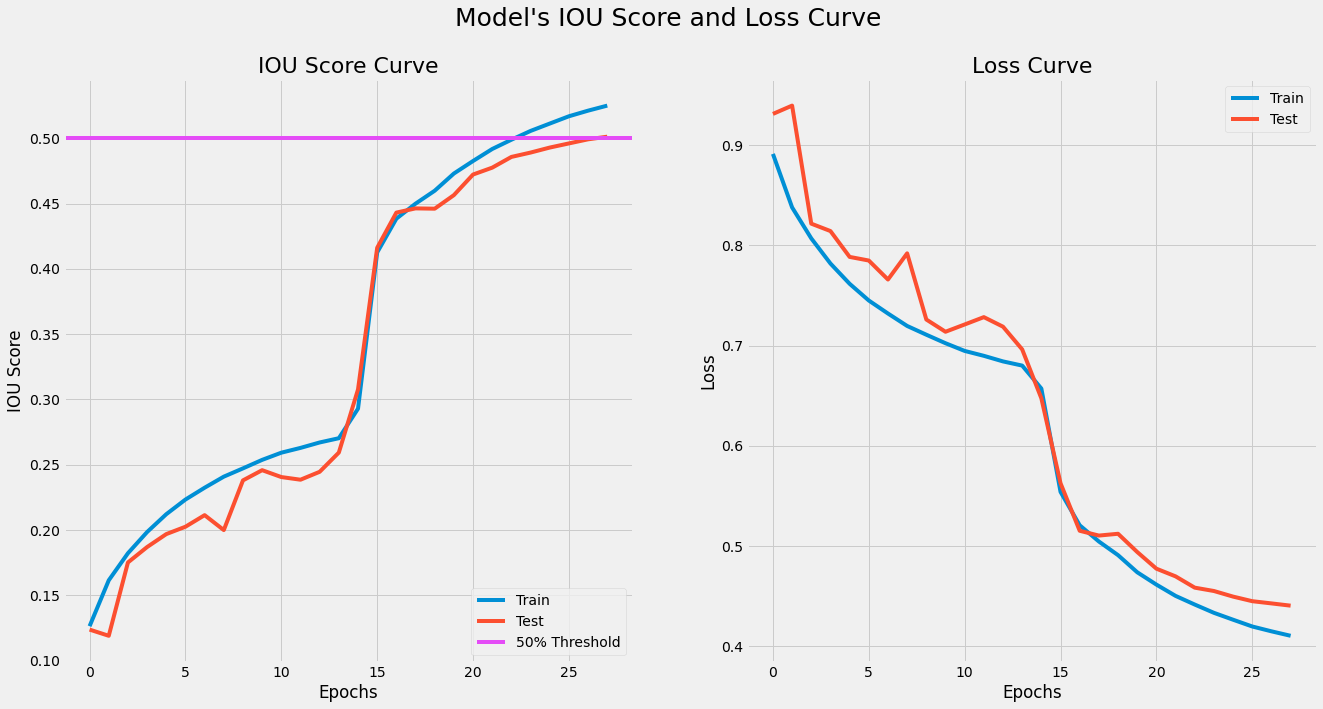

In [35]:
# Plot training & validation iou_score values

plt.figure(figsize=(20, 10))
plt.suptitle("Model's IOU Score and Loss Curve", size = 25)
plt.subplot(121)
plt.plot(combined['iou_score'], label = 'Train')
plt.plot(combined['val_iou_score'], label = 'Test')
plt.axhline(0.5, color = '#E44CF6', label = '50% Threshold')
plt.title('IOU Score Curve', size = 22)
plt.ylabel('IOU Score')
plt.xlabel('Epochs')
plt.legend(loc = 4)

# Plot training & validation loss values
plt.subplot(122)
plt.plot(combined['loss'], label = 'Train')
plt.plot(combined['val_loss'], label = 'Test')
plt.title('Loss Curve', size = 22)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc = 1)

plt.show()

1/1 [==============================] - 2s 2s/step


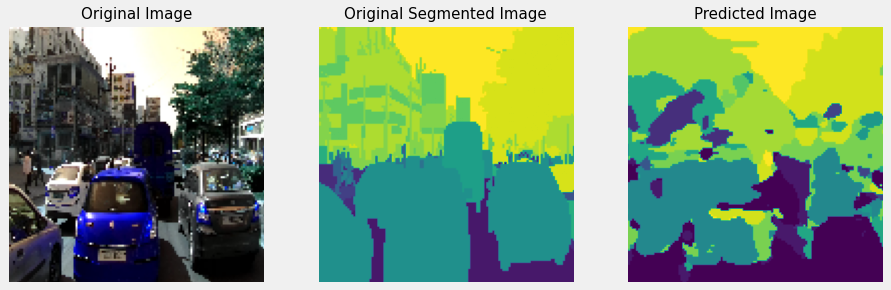

1/1 [==============================] - 0s 19ms/step


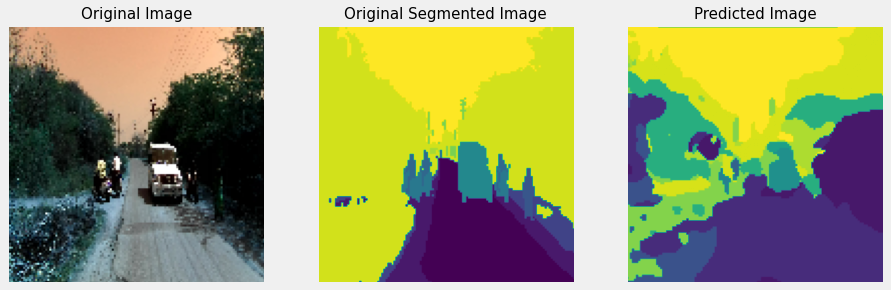

1/1 [==============================] - 0s 21ms/step


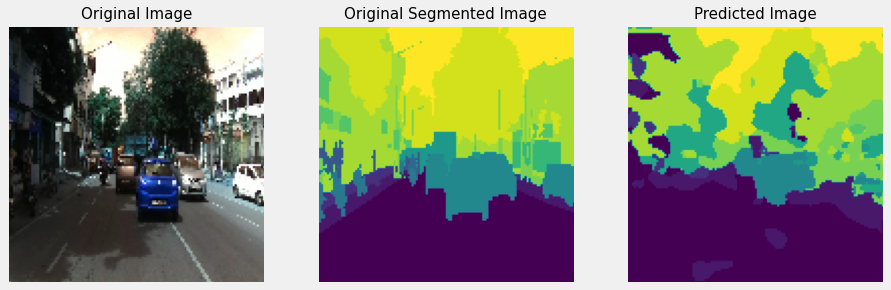

1/1 [==============================] - 0s 18ms/step


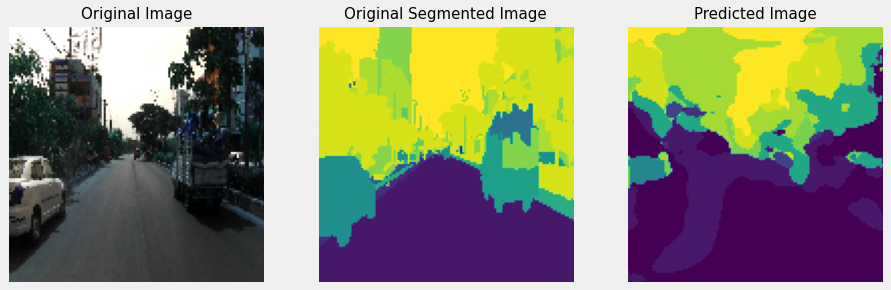

1/1 [==============================] - 0s 17ms/step


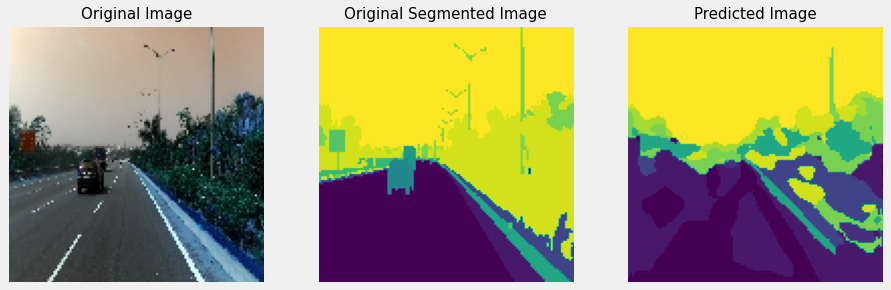

1/1 [==============================] - 0s 18ms/step


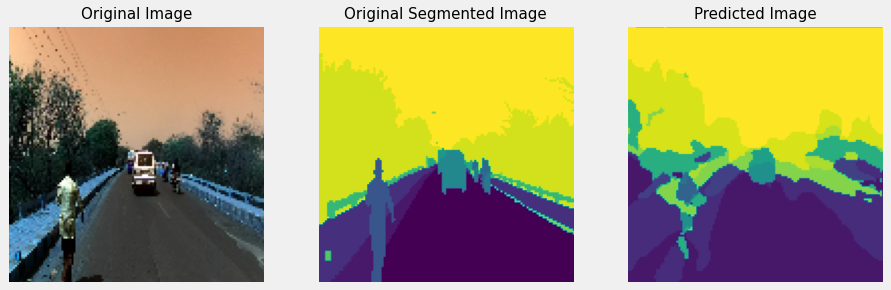

1/1 [==============================] - 0s 19ms/step


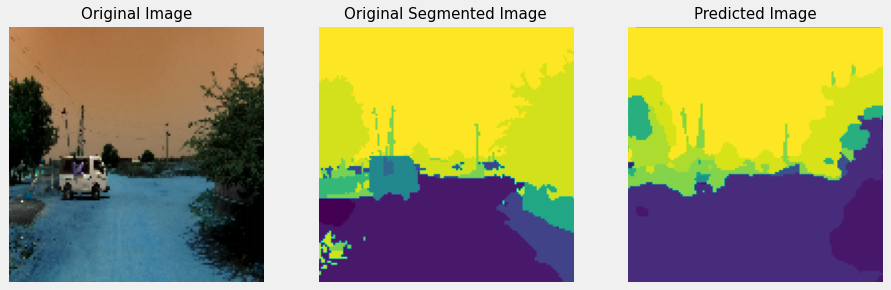

1/1 [==============================] - 0s 27ms/step


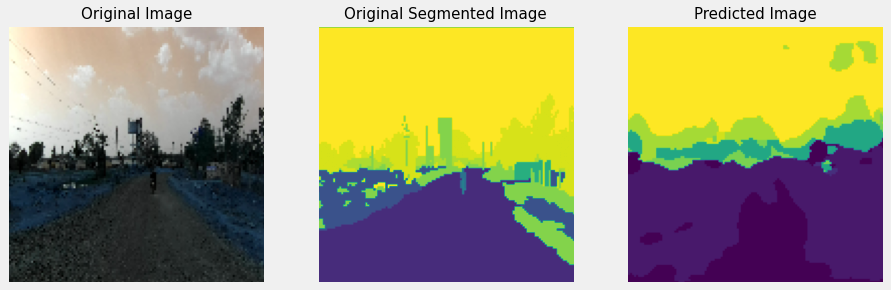

1/1 [==============================] - 0s 22ms/step


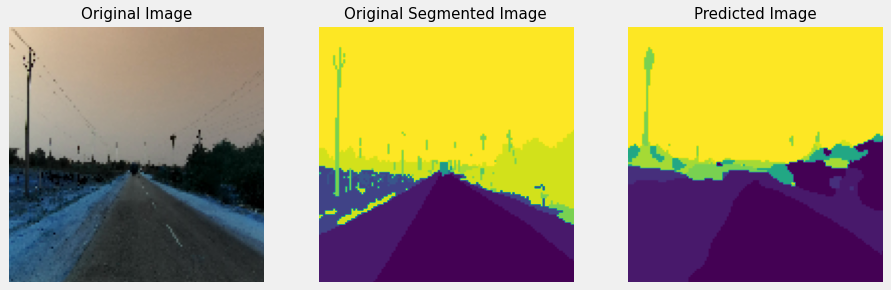

1/1 [==============================] - 0s 22ms/step


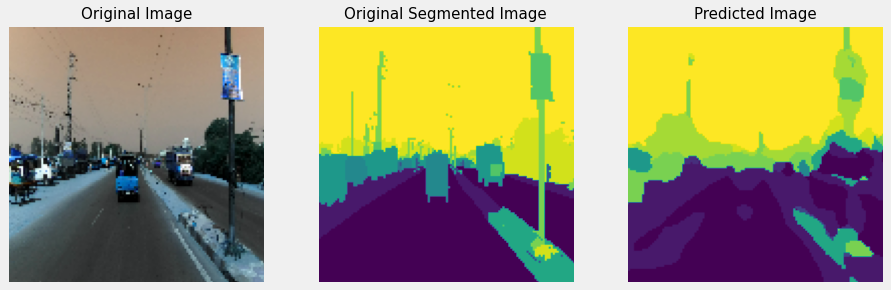

1/1 [==============================] - 0s 19ms/step


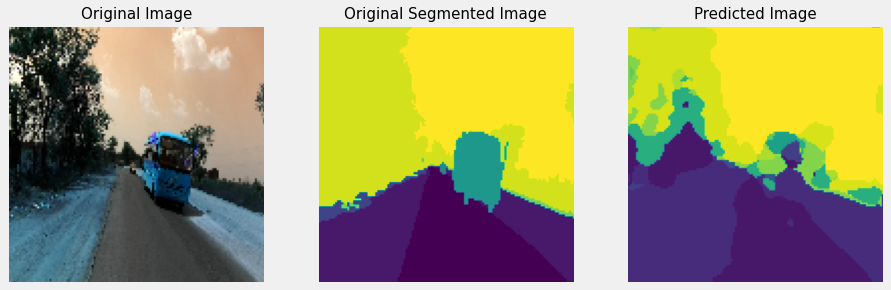

1/1 [==============================] - 0s 18ms/step


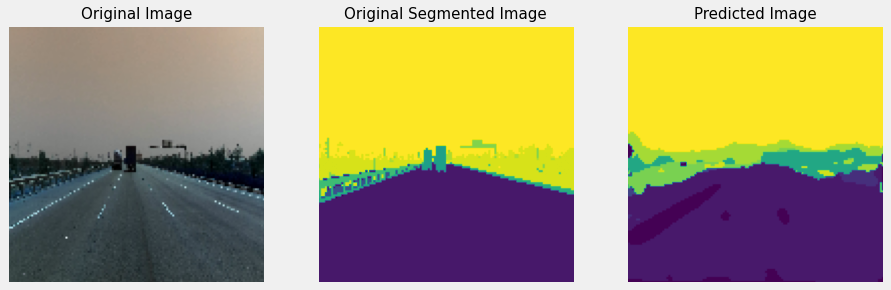

1/1 [==============================] - 0s 17ms/step


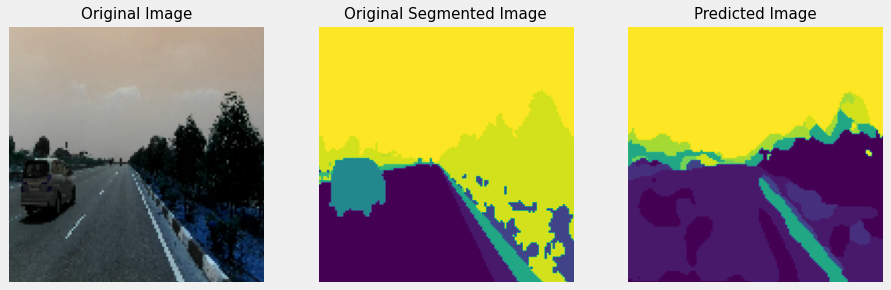

1/1 [==============================] - 0s 17ms/step


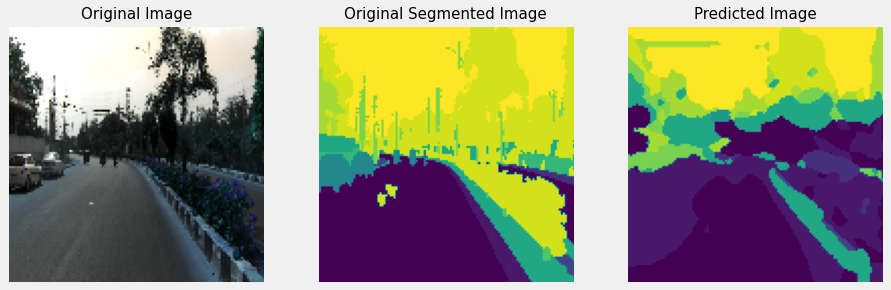

1/1 [==============================] - 0s 19ms/step


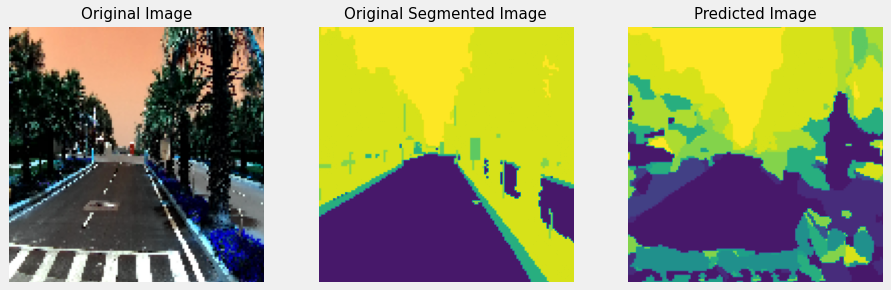

1/1 [==============================] - 0s 17ms/step


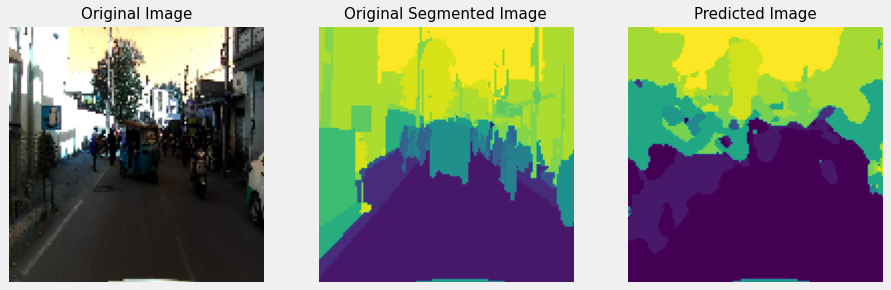

1/1 [==============================] - 0s 17ms/step


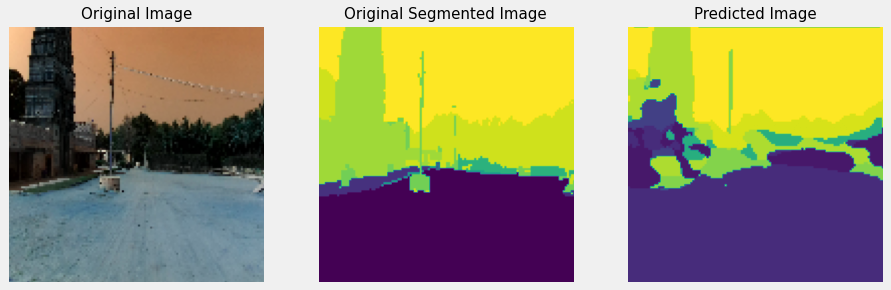

1/1 [==============================] - 0s 17ms/step


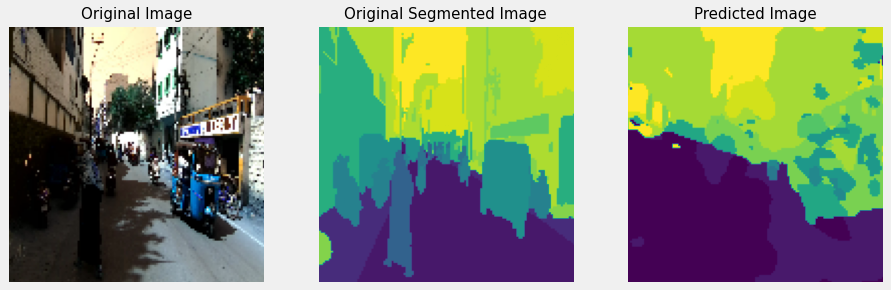

1/1 [==============================] - 0s 68ms/step


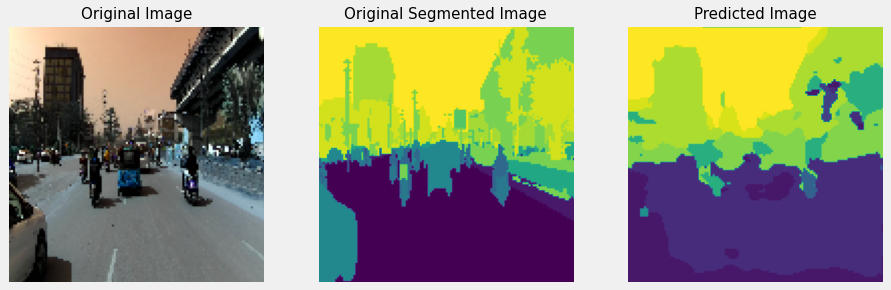

1/1 [==============================] - 0s 18ms/step


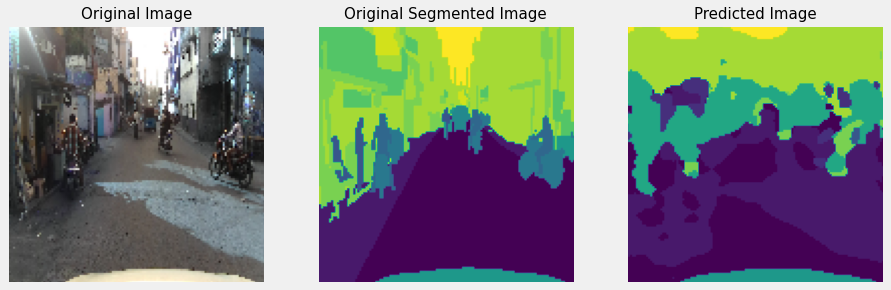

In [37]:
random_img_idx = np.random.choice(np.arange(X_test.shape[0]), size = 20, replace = False)

for idx in random_img_idx:

    # Reading original image
    image_ = cv2.imread(X_test.iloc[idx]['image'], cv2.IMREAD_UNCHANGED)
    image_ = cv2.resize(image_, (IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)

    # Reading segmented image
    image_mask_ = cv2.imread(X_test.iloc[idx]['mask'], cv2.IMREAD_UNCHANGED)
    image_mask_ = cv2.resize(image_mask_, (IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)

    # Generating predicted image
    pred_mask_ = model_unet.predict(image_[np.newaxis,:,:,:])
    pred_mask_ = tf.argmax(pred_mask_, axis = -1)

    plt.rcParams['axes.grid'] = False
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['ytick.labelleft'] = False

    plt.figure(figsize = (14,5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(image_)
    plt.subplot(132)
    plt.title('Original Segmented Image')
    plt.imshow(image_mask_)
    plt.subplot(133)
    plt.title('Predicted Image')
    plt.imshow(pred_mask_[0])
    plt.show()

!cp -r /content/results /content/drive/MyDrive/AAIC